In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import importlib
import sys
sys.path.append('/Retail')
import BuildTsModel
importlib.reload(BuildTsModel)
from BuildTsModel import plot_forecast, evaluate_forecast, residcheck
# set plot style to ggplot2
plt.style.use('ggplot')
# maximize the size of the labels, ticks, and figures
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# legend settings
plt.rcParams['legend.fontsize'] = 10

In [2]:
# import the training and testing data
train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
train = train.squeeze()
train.index.freq = 'MS'
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)
test = test.squeeze()
test.index.freq = 'MS'

# Decompose the series into Trend, Seasonal and white noise components

The equation for time series decomposition with additive trend and seasonality is:



$Y_t = T_t + S_t + E_t$



Where:

- `Yₜ` represents the observed value at time `t`.
- `Tₜ` represents the trend component at time `t`.
- `Sₜ` represents the seasonal component at time `t`.
- `Eₜ` represents the error or residual component at time `t`.

In this model, the trend component (`Tₜ`) captures the long-term systematic increase or decrease in the time series. The seasonal component (`Sₜ`) represents the periodic fluctuations or patterns that repeat over fixed intervals, such as daily, weekly, or yearly patterns, in this case it is yearly. The error component (`Eₜ`) represents the random and unpredictable fluctuations or noise in the data.

We can use this equation to decompose the time series and analyze the individual components.


# Trend

In [3]:
# To remove the seasoanl variation (seasonal adjustment),
# we need  to Centered Moving Average (CMA) based on seasonal period = 12 months
# However, since the seasoanl period is even, we need to take the double moving average (DMA)
ma  = train.rolling(12, center=True).mean()
cma = ma.rolling(2, center=False).mean()

# Seasoanlity

In [4]:
# Deaseasoanlize the series to understand the overall trend and change in sesonality
seasonal_indices = train - cma
# Take the average of the seasonal factors for each month
seasonal_indices =seasonal_indices.groupby(seasonal_indices.index.month).mean()

# The sum of the seasonal indices for additive seasonality should ideally be close to zero
# print the sum of the original numbers
print("Total seasonal indices: ", sum(seasonal_indices))

# Step 2: Determine the correction factor
adjustment_factor = np.mean(seasonal_indices)

# Step 4: Adjust the numbers by adding the correction factor
seasonal_indices = seasonal_indices - adjustment_factor

# print the sum of the corrected numbers
print("Total seasonal indices after correction: ",sum(seasonal_indices))

# Calculate number of years in train set
n_years = len(train.groupby(pd.Grouper(freq='Y')))

# Repeat the correction factor for each month till the end of the training data
seasonal_indices_series = np.tile(seasonal_indices, n_years)

# Truncate the seasonal indices to match the length of the training data
seasonal_indices_series = seasonal_indices_series [:len(train)]

# Create a pandas series of the corrected seasonal indices 
seasonal_indices_series = pd.Series(seasonal_indices_series, 
                                       index=pd.date_range(start='1992-01-01', end='2021-04-01', freq='MS'))

# Compute the change between consecutive seasonal indices
percentage_change = seasonal_indices.diff() / seasonal_indices.shift(1) * 100

seasoanl_indices_pct = pd.Series(percentage_change, index=seasonal_indices.index)

Total seasonal indices:  8.783829750512012
Total seasonal indices after correction:  -1.4210854715202004e-14


In [5]:
# Create a dataframe that includes the seasoanl indices in original, percentage terms and relative strength
seasonal_indices_df = pd.DataFrame({'seasonal_indices': seasonal_indices, 
                                    'seasonal_indices_change':seasonal_indices.diff(),
                                    'seasonal_indices_percent':abs(seasoanl_indices_pct)})
seasonal_indices_df = seasonal_indices_df.round(2)
seasonal_indices_df



,seasonal_indices,seasonal_indices_change,seasonal_indices_percent
1,-48.42,NaN,NaN
2,-51.76,-3.34,6.89
3,2.53,54.29,104.89
4,-9.33,-11.86,468.83
5,19.59,28.93,309.90
6,6.82,-12.77,65.20
7,5.36,-1.46,21.45
8,14.77,9.41,175.69
9,-18.41,-33.18,224.70
10,-4.73,13.68,74.29


In [6]:
# save the seasonal indices to a csv file
seasonal_indices_df.to_csv('seasonal_indices.csv')
# read the seasonal indices from the csv file
seasonal_indices_df = pd.read_csv('seasonal_indices.csv', index_col=0, parse_dates=True)
seasonal_indices_df = seasonal_indices_df.squeeze()
seasonal_indices_df.index.freq = 'MS'


In [7]:
seasonal_indices

1    -48.421881
2    -51.760053
3      2.530630
4     -9.333777
5     19.591633
6      6.818616
7      5.356026
8     14.766266
9    -18.413747
10    -4.733376
11     3.208138
12    80.391526
Name: sales_amount, dtype: float64

In [8]:
# Set the template to ggplot2
pio.templates.default = "ggplot2"

# Create a trace for the seasonal indices
trace = go.Scatter(x=list(range(1, len(seasonal_indices_df.iloc[:,0]) + 1)),
                   y=seasonal_indices_df.iloc[:,0],
                   mode='lines',
                   line=dict(color='blue', width=2),
                   name='Seasonal Indices',
                   text=[f"{round(index, 2)}" for index in seasonal_indices_df.iloc[:,0]])

# Create a trace for the annotations
annotations = []
for index, row in seasonal_indices_df.iterrows():
    annotations.append(dict(x=index + 1, y=row['seasonal_indices'], text=f"{row['seasonal_indices']}",
                            font=dict(size=10)))

# Create a layout for the plot
layout = go.Layout(title=dict(text="<b>Seasonal Indices in Billions of Dollars for Advance Retail Sales in US: Retail Trade</b> ", font=dict(size=20)),
                   xaxis=dict(title=dict(text='<b>Month</b>', font=dict(size=20)),
                              tickfont=dict(size=15),
                              dtick=1),
                   yaxis=dict(title=dict(text='<b>Billions of 2023 Dollars </b>', font=dict(size=20)),
                              tickfont=dict(size=15)),
                   hovermode='x',
                   hoverlabel=dict(bgcolor='white', font=dict(size=15)),
                   margin=dict(l=50, r=50, t=80, b=50),
                   legend=dict(x=0.05, y=0.95, bgcolor='white', bordercolor='gray', borderwidth=1, font=dict(size=12)))

# Create a figure and plot the data
fig = go.Figure(data=[trace], layout=layout)
fig.update_yaxes(tickfont_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black")

def hovertext(value, percent):
    if value > 0:
        return f"<b>Change: <span style='color:green'>{value} ({percent}%)</span></b>"
    else:
        return f"<b>Change: <span style='color:red'>{value} ({percent}%)</span></b>"

# fig.update_traces(hovertemplate='%{y:.2f}<extra></extra>')
fig.update_traces(text=[hovertext(value, percent) if pd.notna(value) else 'N/A' for value, percent in zip(seasonal_indices_df.iloc[:,1], seasonal_indices_df.iloc[:,2])])
fig.show()

The seasonal indices provide valuable insights into the comparison between each season and the yearly average, indicating whether values are lower or higher by a specific amount or percentage. For instance, the seasonal index for January reveals a decrease of $46.64 billion, indicating that January sales are below the yearly average. On the other hand, the seasonal index for December shows an impressive increase of $77.40 billion, representing a significant rise of 2397.7% compared to the previous month. This remarkable surge suggests that December sales surpass the yearly average, outperforming all other months. This analysis aligns perfectly with the expected pattern, as sales typically experience a surge towards the end of the year due to Christmas and other major sales events. Consequently, sales observe a notable decline as people reduce their purchasing activities after the holiday season.

# Residuals

In [9]:
# Extract the white noise component
residuals = train - cma - seasonal_indices_series

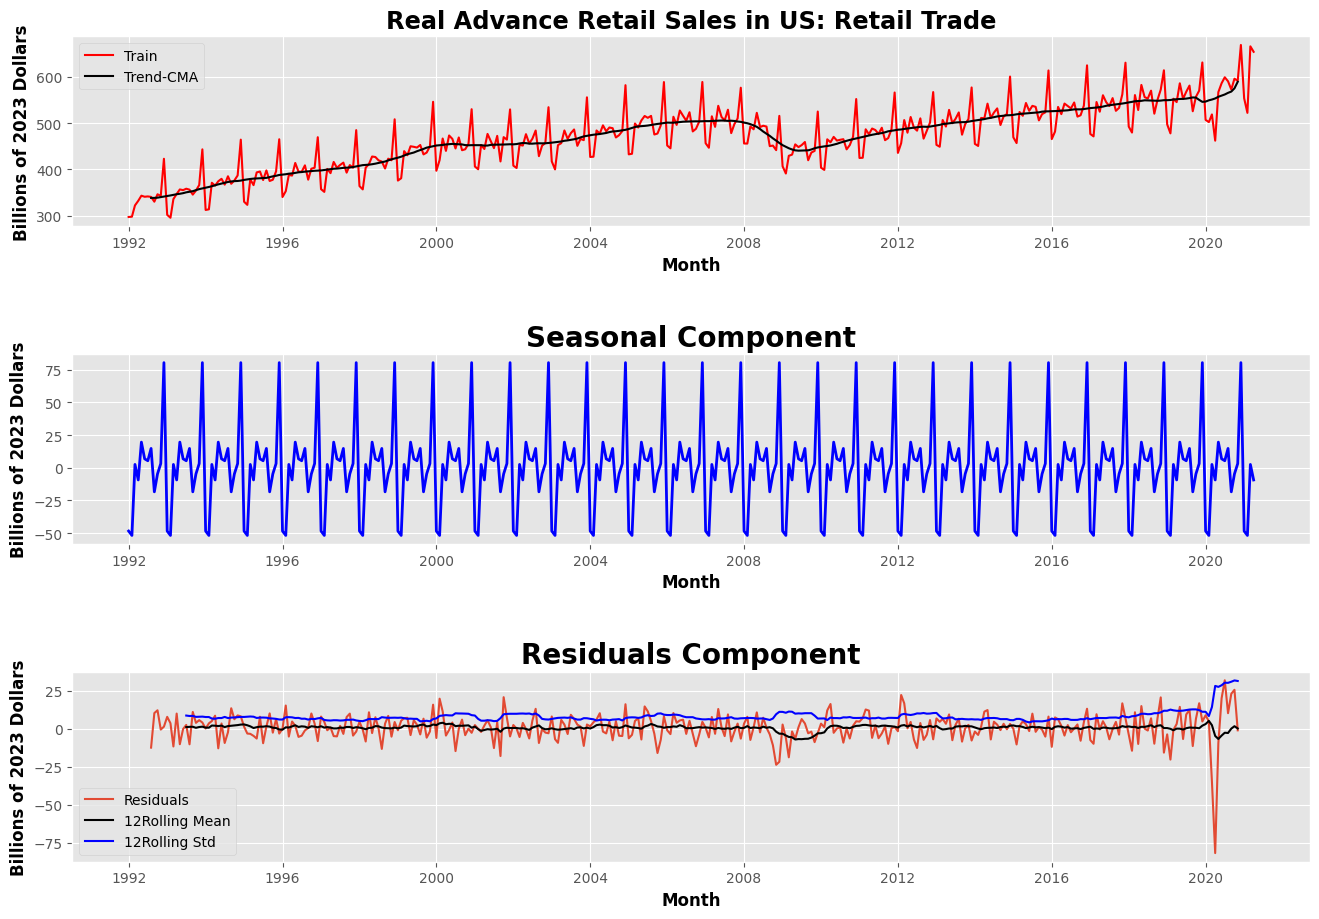

In [10]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Plot the training data and trend component
ax1.plot(train, color='red')
ax1.plot(cma, color='black')
ax1.set_title("Real Advance Retail Sales in US: Retail Trade", color='black', weight='bold')
ax1.set_xlabel('Month', color='black', weight='bold')
ax1.set_ylabel('Billions of 2023 Dollars', color='black', weight='bold')
ax1.legend(['Train', "Trend-CMA"])

# Plot the seasonal component
ax2.plot(seasonal_indices_series, color='blue', linewidth=2)
ax2.set_title('Seasonal Component', fontsize=20, weight='bold')
ax2.set_xlabel('Month', color='black', weight='bold')
ax2.set_ylabel('Billions of 2023 Dollars', color='black', weight='bold')

# Plot the residuals component
ax3.plot(residuals, label='Residuals')
ax3.set_title('Residuals Component', fontsize=20, weight='bold')
ax3.set_xlabel('Month', color='black', weight='bold')
ax3.set_ylabel('Billions of 2023 Dollars', color='black', weight='bold')
ax3.plot(residuals.rolling(window=12).mean(), color='black', label='12Rolling Mean')
ax3.plot(residuals.rolling(window=12).std(), color='blue', label='12Rolling Std')
ax3.legend(loc='best')

# Set the x-axis limits for the residuals subplot to be the same as the x-axis limits for the other subplots
ax3.set_xlim(ax1.get_xlim())

# Adjust the layout and spacing of the subplots
fig.tight_layout(pad=3.0)

# Show the plot
plt.show()

In [11]:
# save cmap, seasonal indices and residuals
cma.to_csv('cma.csv')
seasonal_indices_series.to_csv('seasonal_indices_series.csv')
residuals.to_csv('residuals.csv')


# Forecasting decomposed components

We will include only the data after the financial crisis, as the behavior of retail sales has undergone a significant change during this period and no longer represents the current behavior. By focusing on the post-crisis data, our model can better capture the recent patterns and dynamics, which are more relevant for accurate forecasting.

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Exclude the financial crisis period and null values
cma_excl_crisis = cma['2009-06-01':'2020-11-01']
# The gap between the last training data point and the first test data point
# This gap is due the smoothing of the trend component with cma 
gap = 5
cma_train_time = np.arange(1, len(cma_excl_crisis) + 1)
cma_test_time = np.arange(len(cma_excl_crisis)+ gap, len(cma_excl_crisis) + gap + len(test))

# create the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(cma_train_time.reshape(-1, 1), cma_excl_crisis.values)

# predict the values for the training data
lr_fitted_values = model.predict(cma_train_time.reshape(-1, 1))

# predict the values for the test data
lr_predictions = model.predict(cma_test_time.reshape(-1, 1))

# calculate the residuals of the linear regression model
lr_resid = cma_excl_crisis - lr_fitted_values

** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.057 (>0.05, Non-stationary)


(<Axes: >,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: xlabel='sales_amount', ylabel='Density'>)

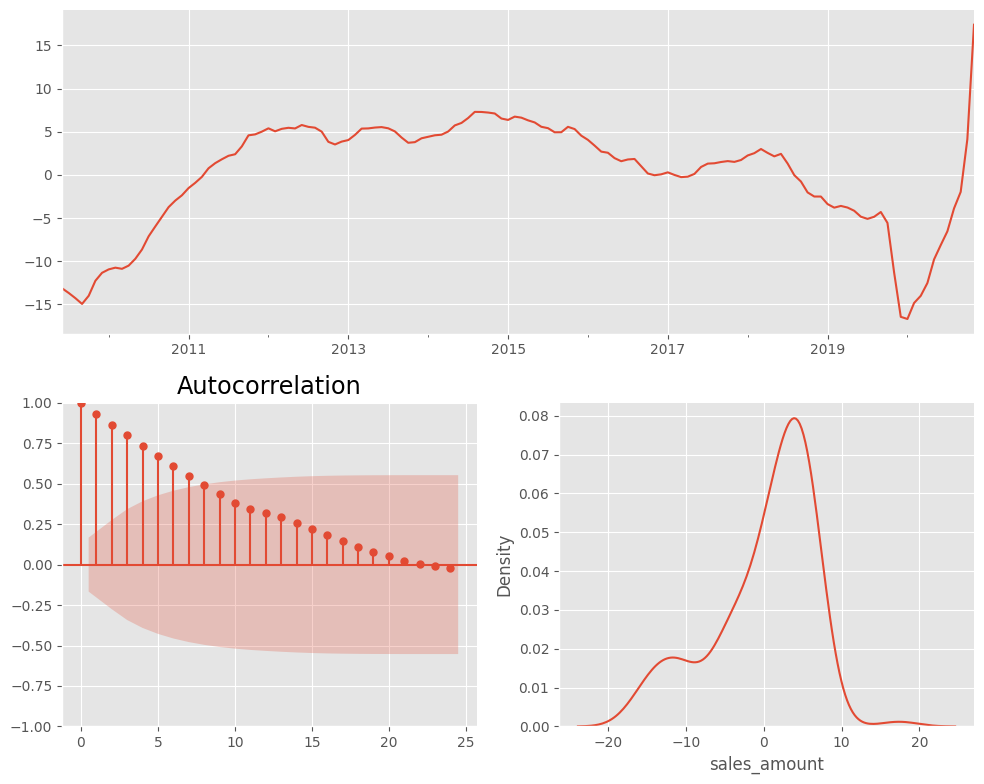

In [13]:
residcheck(lr_resid, 24)

In [14]:
# construct a seasoanl Naive model for the next 24 months
snaive = [seasonal_indices_df['seasonal_indices'].iloc[(i+4) % 12] for i in range(len(test))]
snaive = pd.Series(snaive, index=test.index)

# since the trend and seasoanlity are additve, we need to add the trend to the seasonal naive forecast
recomposed_fcst = lr_predictions + snaive
# Exclude the financial crisis period and null values from orignial training data
train_excl_crisis = train['2009-06-01':'2020-11-01']
# Generate the seasonal naive fitted values
snaive_fittedvalues = [seasonal_indices_df['seasonal_indices'].iloc[(i+5) % 12] for i in range(len(train_excl_crisis))]
# Recompose the fitted values by adding the trend and seasonal naive fitted values
recomposed_fittedvalues = snaive_fittedvalues + lr_fitted_values 
# Calculate the residuals by subtracting the recomposed fitted values from the original training data
recomposed_residuals = train_excl_crisis - recomposed_fittedvalues 
# Calculate the mean of the residuals to adjust for relative high variability during COVID-19
cov_residuals_mean = abs(recomposed_residuals['2020-03-01':]).mean()
# Add the mean of the residuals to the forecast
recomposed_fcst_with_residmu = recomposed_fcst  + cov_residuals_mean

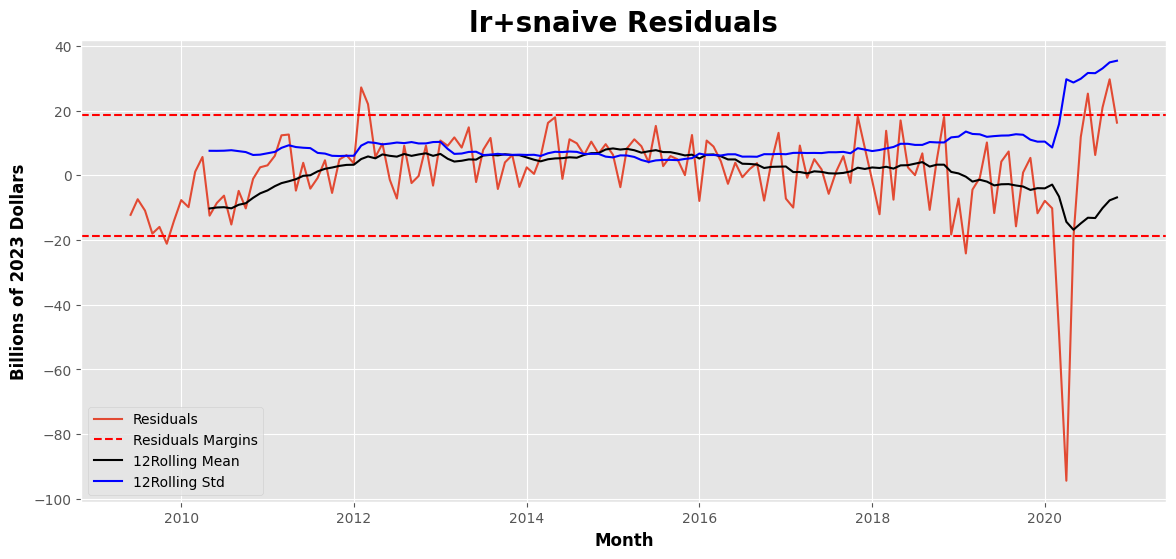

In [15]:
# Calculate the residuals margins to have a better view of the residuals variability
# The residuals margins are set to 10% of the range of the training data
residuals_margins = (train.max()-train.min())*0.05
# Analyze the residuals
plt.plot(recomposed_residuals, label='Residuals')
plt.title('lr+snaive Residuals', fontsize=20, weight='bold')
plt.xlabel('Month', color='black', weight='bold')
plt.ylabel('Billions of 2023 Dollars', color='black', weight='bold')
# Plot the residuals margins
plt.axhline(y=residuals_margins, color='red', linestyle='--', label='Residuals Margins')
plt.axhline(y=-residuals_margins, color='red', linestyle='--')

# Perform local check by plotting the rolling mean and standard deviation
plt.plot(recomposed_residuals.rolling(window=12).mean(), color='black', label='12Rolling Mean')
plt.plot(recomposed_residuals.rolling(window=12).std(), color='blue', label='12Rolling Std')
plt.legend(loc='best')
plt.show()


To address the recent impact of COVID-19, which has led to higher variance in the residuals, we will incorporate the absolute mean of the residuals from the COVID-19 period into the forecasted values. This adjustment aims to mitigate any systematic biases or errors that the model may have encountered in capturing the effects of the pandemic. By acknowledging the presence of larger residuals during the COVID-19 period, which indicate increased uncertainty and volatility, we account for the potential variability and uncertainty in the forecasted values. Adding the mean of the absolute residuals as a margin of error provides a quantifiable measure of the specific effects of the pandemic on the forecasted values.

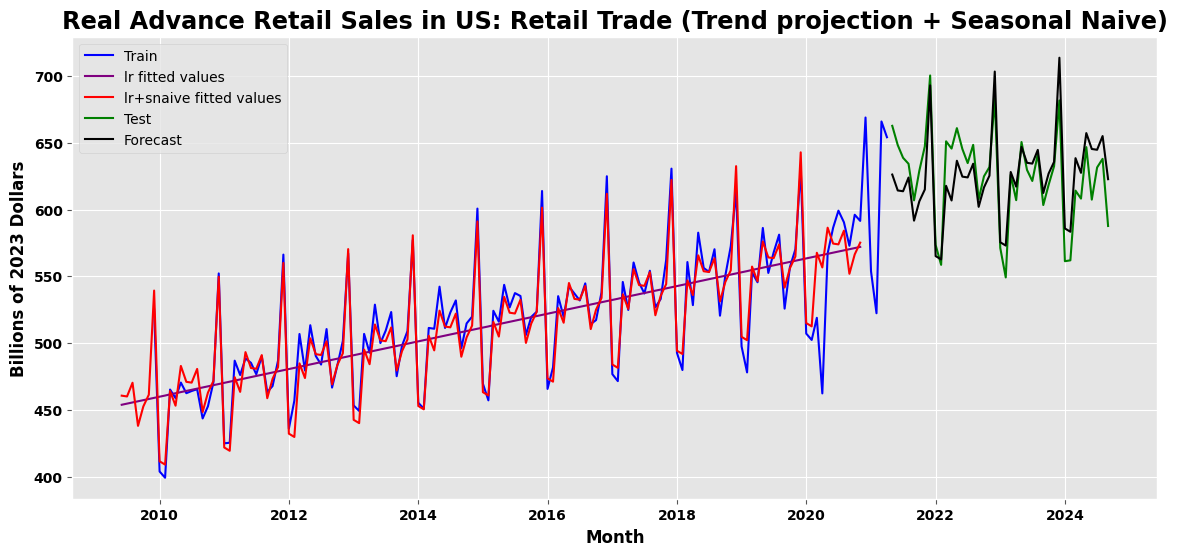

In [16]:
plt.plot(train.index[215:], train[215:], label='Train', color='blue')
plt.plot(cma_excl_crisis.index, lr_fitted_values, label='lr fitted values', color='purple')
plt.plot(cma_excl_crisis.index, recomposed_fittedvalues, label='lr+snaive fitted values', color='red')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, recomposed_fcst_with_residmu, label='Forecast', color='black')

plt.legend()

# set label properties
plt.title("Real Advance Retail Sales in US: Retail Trade (Trend projection + Seasonal Naive)", color='black', weight='bold')
plt.setp(plt.gca().get_xticklabels(), color='black', weight='bold')
plt.setp(plt.gca().get_yticklabels(), color='black', weight='bold')
plt.xlabel('Month', color='black', weight='bold')
plt.ylabel('Billions of 2023 Dollars', color='black', weight='bold')

# show the plot
plt.show()



In [17]:
evaluate_forecast('lr+snavie', recomposed_fcst_with_residmu, test)

{'Model': 'lr+snavie', 'MAE': 17.0873, 'RMSE': 20.396, 'MAPE': 2.7368}

Although the evaluation of the model predictive power shows promising results, the diagnostic checks on the residuals reveal that multiple assumptions have been violated, both when using only the linear model and when using also the linear model with seasonal naive. In both cases, the resulting residuals fail to meet the assumptions necessary for constructing reliable predicted intervals.

The residuals obtained in both cases display violations such as autocorrelation, non-constant variance, non-normality, and a non-zero mean. These violations significantly undermine the reliability of predicted intervals as a measure of uncertainty surrounding the forecasted point estimates.

Consequently, it is not possible to establish dependable predicted intervals that accurately quantify the uncertainty associated with the forecasted values.

To address this issue, it is crucial to explore alternative methods that can best fit the data.